In [1]:
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt

## Linear kinematic hardening
model from lecture

In [2]:
E = 10
H = 1

sigmaY = 0.5

def fhat(sigmahat): return np.abs(sigmahat) - sigmaY

max_stress = 0.6

In [3]:
def psi(eps, epsp):
    return 1/2*E*(eps-epsp)**2 + 1/2*H*epsp**2

def delta_psi(eps, epsp, delta_eps, delta_epsp):
    return psi(eps+delta_eps,epsp+delta_epsp) - psi(eps,epsp)
    

def phi(delta_epsp):
    return sigmaY*np.abs(delta_epsp)

def objective_function(x, eps, epsp, sigma):
    delta_eps = x[0]
    delta_epsp = x[1]

    return delta_psi(eps, epsp, delta_eps, delta_epsp) + phi(delta_epsp) - sigma*delta_eps

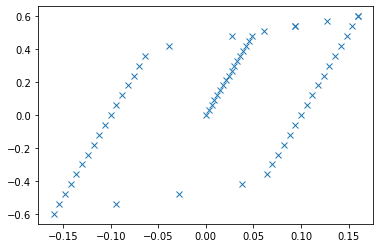

In [4]:


nsteps = 20
stress_list_vi = np.linspace(0,max_stress,nsteps+1)
stress_list_vi = np.concatenate((np.linspace(0,max_stress,nsteps, endpoint=False),np.linspace(max_stress,-max_stress,nsteps, endpoint=False),np.linspace(-max_stress,max_stress,nsteps+1)))

eps_list_vi = [0]
epsp_list_vi = [0]


for i in range(len(stress_list_vi)-1):
    x0 = np.array([0,0])

    result = minimize(objective_function, x0, (eps_list_vi[i], epsp_list_vi[i], stress_list_vi[i+1]), method="Powell")

    eps_list_vi.append(eps_list_vi[i]+result.x[0])
    epsp_list_vi.append(epsp_list_vi[i]+result.x[1])
    if not result.success:
        print("scipy minimization failed")
        break

plt.plot(eps_list_vi, stress_list_vi, "x")

## Multi-yield plasticity
use set of $N=3$ plastic strains, hardening modules and yield stresses:
$$\varepsilon = \varepsilon_e + \sum_{i=1}^N \varepsilon_{p,i}, \qquad
\phi = \sum_{i=1}^N \sigma_{Y,i} |\dot \varepsilon_{p,i}|,\qquad
\psi = \frac{1}{2} E \varepsilon_e^2 + \sum_{i=1}^N \frac{1}{2}H_i \varepsilon_{p,i}^2$$

In [5]:
E = 10
H = np.array([5,2,1])

sigmaY = np.array([0.3,0.5,0.55])

N = len(H)

In [6]:
def psi(eps, epsp):
    return 1/2*E*(eps-sum(epsp))**2 + sum([1/2*H[i]*epsp[i]**2 for i in range(N)])

def delta_psi(eps, epsp, delta_eps, delta_epsp):
    return psi(eps+delta_eps,epsp+delta_epsp) - psi(eps,epsp)
    

def phi(delta_epsp):
    return sum([sigmaY[i]*np.abs(delta_epsp[i]) for i in range(N)])

def objective_function(x, eps, epsp, sigma):
    delta_eps = x[0]
    delta_epsp = x[1:N+1]

    return delta_psi(eps, epsp, delta_eps, delta_epsp) + phi(delta_epsp) - sigma*delta_eps

In [7]:
nsteps = 50
stress_list_vi = np.linspace(0,max_stress,nsteps+1)
stress_list_vi = np.concatenate((np.linspace(0,max_stress,nsteps, endpoint=False),np.linspace(max_stress,-max_stress,nsteps, endpoint=False),np.linspace(-max_stress,max_stress,nsteps+1)))

eps_list_vi = [0]
epsp_list_vi = [np.zeros(N)]


for i in range(len(stress_list_vi)-1):
    x0 = np.zeros(N+1)

    result = minimize(objective_function, x0, (eps_list_vi[i], epsp_list_vi[i], stress_list_vi[i+1]), method="Powell")

    eps_list_vi.append(eps_list_vi[i]+result.x[0])
    epsp_list_vi.append(epsp_list_vi[i]+result.x[1:])
    if not result.success:
        print("scipy minimization failed")
        break

plt.plot(eps_list_vi, stress_list_vi, "-")

## Linear isotropic hardening
Introduce accumulated plastic strain $\alpha$, $\dot \alpha = |\dot \varepsilon_p|$:
$$\varepsilon = \varepsilon_e +  \varepsilon_{p}, \qquad
\phi = \sigma_{Y} |\dot \varepsilon_{p}|,\qquad
\psi = \frac{1}{2} E \varepsilon_e^2 + \frac{1}{2}H \alpha^2$$

In [46]:
E = 10
H = 1

sigmaY = 0.5

max_stress = 0.6

In [47]:
    
def psi(eps, epsp, alpha):
    return 1/2*E*(eps-epsp)**2 + 1/2*H*alpha**2

def delta_psi(eps, epsp, alpha, delta_eps, delta_epsp, delta_alpha):
    return psi(eps+delta_eps,epsp+delta_epsp,alpha+delta_alpha) - psi(eps,epsp,alpha)
    

def phi(delta_epsp):
    return sigmaY*np.abs(delta_epsp)

def objective_function(x, eps, epsp, alpha, sigma):
    delta_eps = x[0]
    delta_epsp = x[1]
    delta_alpha = np.abs(delta_epsp)


    return delta_psi(eps, epsp, alpha, delta_eps, delta_epsp, delta_alpha) + phi(delta_epsp) - sigma*delta_eps

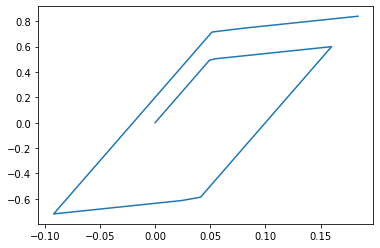

In [48]:


nsteps = 50
stress_list_vi = np.linspace(0,max_stress,nsteps+1)
stress_list_vi = np.concatenate((np.linspace(0,max_stress,nsteps, endpoint=False),np.linspace(max_stress,-1.2*max_stress,nsteps, endpoint=False),np.linspace(-1.2*max_stress,1.4*max_stress,nsteps+1)))

eps_list_vi = [0]
epsp_list_vi = [0]
alpha_list = [0]


for i in range(len(stress_list_vi)-1):
    x0 = np.array([0,0])

    result = minimize(objective_function, x0, (eps_list_vi[i], epsp_list_vi[i], alpha_list[i], stress_list_vi[i+1]), method="Powell")

    eps_list_vi.append(eps_list_vi[i]+result.x[0])
    epsp_list_vi.append(epsp_list_vi[i]+result.x[1])
    alpha_list.append(alpha_list[i] + np.abs(result.x[1]))
    if not result.success:
        print("scipy minimization failed")
        break

plt.plot(eps_list_vi, stress_list_vi)

## Nonlinear isotropic hardening
Use accumulated plastic strain $\alpha$, $\dot \alpha = |\dot \varepsilon_p|$ with Ludwik-Hollomon energy density ($n \leq 1$, linear case retained for $n=1$)
$$\varepsilon = \varepsilon_e +  \varepsilon_{p}, \qquad
\phi = \sigma_{Y} |\dot \varepsilon_{p}|,\qquad
\psi = \frac{1}{2} E \varepsilon_e^2 + \frac{1}{1+n}H \alpha^{1+n}$$

In [61]:
E = 10
H = 1
n = 0.5

sigmaY = 0.5

max_stress = 0.6

In [62]:
    
def psi(eps, epsp, alpha):
    return 1/2*E*(eps-epsp)**2 + 1/(n+1)*H*alpha**(n+1)

def delta_psi(eps, epsp, alpha, delta_eps, delta_epsp, delta_alpha):
    return psi(eps+delta_eps,epsp+delta_epsp,alpha+delta_alpha) - psi(eps,epsp,alpha)
    

def phi(delta_epsp):
    return sigmaY*np.abs(delta_epsp)

def objective_function(x, eps, epsp, alpha, sigma):
    delta_eps = x[0]
    delta_epsp = x[1]
    delta_alpha = np.abs(delta_epsp)


    return delta_psi(eps, epsp, alpha, delta_eps, delta_epsp, delta_alpha) + phi(delta_epsp) - sigma*delta_eps

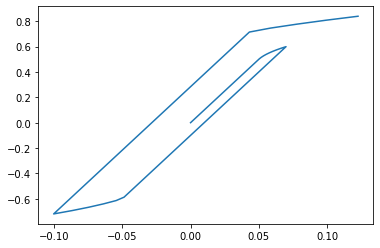

In [63]:


nsteps = 50
stress_list_vi = np.linspace(0,max_stress,nsteps+1)
stress_list_vi = np.concatenate((np.linspace(0,max_stress,nsteps, endpoint=False),np.linspace(max_stress,-1.2*max_stress,nsteps, endpoint=False),np.linspace(-1.2*max_stress,1.4*max_stress,nsteps+1)))

eps_list_vi = [0]
epsp_list_vi = [0]
alpha_list = [0]


for i in range(len(stress_list_vi)-1):
    x0 = np.array([0,0])

    result = minimize(objective_function, x0, (eps_list_vi[i], epsp_list_vi[i], alpha_list[i], stress_list_vi[i+1]), method="Powell")

    eps_list_vi.append(eps_list_vi[i]+result.x[0])
    epsp_list_vi.append(epsp_list_vi[i]+result.x[1])
    alpha_list.append(alpha_list[i] + np.abs(result.x[1]))
    if not result.success:
        print("scipy minimization failed")
        break

plt.plot(eps_list_vi, stress_list_vi)